In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 31 11:42:46 2024

@author: venkatesh
"""

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [8]:
model_name='ShuffleNet2'

num_classes = 4
# Assuming 3 classes: "NORMAL", "DRUSEN", "DME","CNV"

if(model_name=='mobilenetv2'):
    from models.mobilenet import MobileNet2
    model=MobileNet2(in_channels=1, num_classes=4)
if(model_name=='ResNet50'):
    from models.resnet import ResNet50
    model=ResNet50(num_classes=num_classes, channels=1)    
if(model_name=='ShuffleNet2'):
    from models.ShuffleNet2 import ShuffleNet2
    model=ShuffleNet2(num_classes=num_classes,num_inp_channels=1)    
if(model_name=='SqueezeNet'):
    from models.SqueezeNet import SqueezeNet
    model=SqueezeNet(num_classes=num_classes,num_inp_channels=1)

torch.Size([1, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             240
         MaxPool2d-2           [-1, 24, 56, 56]               0
            Conv2d-3           [-1, 24, 28, 28]             216
       BatchNorm2d-4           [-1, 24, 28, 28]              48
            Conv2d-5           [-1, 58, 28, 28]           1,392
       BatchNorm2d-6           [-1, 58, 28, 28]             116
              ReLU-7           [-1, 58, 28, 28]               0
            Conv2d-8           [-1, 58, 56, 56]           1,392
       BatchNorm2d-9           [-1, 58, 56, 56]             116
             ReLU-10           [-1, 58, 56, 56]               0
           Conv2d-11           [-1, 58, 28, 28]             522
      BatchNorm2d-12           [-1, 58, 28, 28]             116
           Conv2d-13           [-1, 58, 28, 28]           3,364
      BatchNorm2d-14

In [10]:
model=model.to(device)


In [11]:
from datetime import datetime
import time

import os
print ('*******************************************************')
start_time=time.time()
experiments_folder="saved_models/"
experiment_name=datetime.now().strftime("%b_%d_%I_%M_%P_")+"_model_"+model_name

directory=experiments_folder+"/"+experiment_name+"/"
print(directory)
print('Model will be saved to  :', directory)

try:
    os.makedirs(directory)
except:
    print('model already existed..........')

*******************************************************
saved_models//Aug_01_04_56_pm__model_ShuffleNet2/
Model will be saved to  : saved_models//Aug_01_04_56_pm__model_ShuffleNet2/


In [12]:
import torchvision.transforms as transforms

# Define transformations for data augmentation or normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to required size
    transforms.ToTensor()
])

In [13]:
from dataset import CustomDataset
from torch.utils.data import Dataset, DataLoader

# Create CustomDataset instance
dataset = CustomDataset('./csv_files/data_train.csv', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset('./csv_files/data_valid.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(train_loader))
print(len(val_dataloader))

print('number of testing images',len(test_dataset))


2166
271
number of testing images 86648


In [14]:


learning_rate=0.0001
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train your model
# Train your model
from tqdm import tqdm

# Define your training function
model.train()
train_losses = []  # List to store training losses
val_losses = []  # List to store validaion losses
train_accuracy=[]
validation_accuracy=[]

num_epochs=25



for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss=0.0
    
    y_true_train = []
    y_pred_train = []


    # Create tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        #print(torch.unique(images))
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        y_pred_train.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})

        
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    train_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, running_loss))
    print("Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
        
    save_path=directory+'/mymodel_'+str(epoch)+'.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at: {save_path}')

    # storing the train losses
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    y_true_val = []
    y_pred_val = []

    
    model.eval()
    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

        y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_val.extend(labels.detach().tolist())

        
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Validation Loss': validation_loss / (batch_idx + 1)})

    # storing the validation losses

    epoch_loss = validation_loss / len(val_dataloader)
    val_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
    total = len(y_true_val)
    accuracy = total_correct * 100 / total
    validation_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Val mean loss: {:.8f}".format(epoch, validation_loss))
    print("valiation Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

    import pandas as pd

    loss_dic={"training_loss":train_losses,
              "val_loss":val_losses,
              "train_accuracy":train_accuracy,
              "validation_accuracy":validation_accuracy}

    df = pd.DataFrame.from_dict(loss_dic) 
    path=directory+'/loss.csv'
    df.to_csv (path, index = False, header=True)

Epoch 1/25: 100%|██████████| 2166/2166 [01:53<00:00, 19.15it/s, Loss=0.892]


-------------------------------------------------
Epoch: 0 Train mean loss: 1931.46987286
Train Accuracy%:  66.62049861495845 == 11544 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_0.pth
Epoch [1/25], Loss: 0.8917


Epoch 1/25: 100%|██████████| 271/271 [00:08<00:00, 32.19it/s, Validation Loss=0.605]


Epoch [1/25], Loss: 0.6047
-------------------------------------------------
Epoch: 0 Val mean loss: 163.88361165
valiation Accuracy%:  77.84956160590679 == 1687 / 2167
-------------------------------------------------


Epoch 2/25: 100%|██████████| 2166/2166 [01:49<00:00, 19.78it/s, Loss=0.614]


-------------------------------------------------
Epoch: 1 Train mean loss: 1330.38248047
Train Accuracy%:  78.62419205909511 == 13624 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_1.pth
Epoch [2/25], Loss: 0.6142


Epoch 2/25: 100%|██████████| 271/271 [00:08<00:00, 32.03it/s, Validation Loss=0.483]


Epoch [2/25], Loss: 0.4832
-------------------------------------------------
Epoch: 1 Val mean loss: 130.94196017
valiation Accuracy%:  82.83341024457776 == 1795 / 2167
-------------------------------------------------


Epoch 3/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.03it/s, Loss=0.459]


-------------------------------------------------
Epoch: 2 Train mean loss: 994.64124816
Train Accuracy%:  84.06048014773776 == 14566 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_2.pth
Epoch [3/25], Loss: 0.4592


Epoch 3/25: 100%|██████████| 271/271 [00:08<00:00, 32.67it/s, Validation Loss=0.404]


Epoch [3/25], Loss: 0.4042
-------------------------------------------------
Epoch: 2 Val mean loss: 109.53318439
valiation Accuracy%:  85.1407475772958 == 1845 / 2167
-------------------------------------------------


Epoch 4/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.04it/s, Loss=0.381]


-------------------------------------------------
Epoch: 3 Train mean loss: 824.94232289
Train Accuracy%:  86.87096029547553 == 15053 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_3.pth
Epoch [4/25], Loss: 0.3809


Epoch 4/25: 100%|██████████| 271/271 [00:08<00:00, 32.20it/s, Validation Loss=0.41] 


Epoch [4/25], Loss: 0.4101
-------------------------------------------------
Epoch: 3 Val mean loss: 111.13715495
valiation Accuracy%:  85.3714813105676 == 1850 / 2167
-------------------------------------------------


Epoch 5/25: 100%|██████████| 2166/2166 [01:47<00:00, 20.09it/s, Loss=0.32] 


-------------------------------------------------
Epoch: 4 Train mean loss: 693.24776951
Train Accuracy%:  88.89081255771006 == 15403 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_4.pth
Epoch [5/25], Loss: 0.3201


Epoch 5/25: 100%|██████████| 271/271 [00:08<00:00, 32.30it/s, Validation Loss=0.331]


Epoch [5/25], Loss: 0.3310
-------------------------------------------------
Epoch: 4 Val mean loss: 89.68768189
valiation Accuracy%:  89.06322104291648 == 1930 / 2167
-------------------------------------------------


Epoch 6/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.87it/s, Loss=0.274]


-------------------------------------------------
Epoch: 5 Train mean loss: 592.87059109
Train Accuracy%:  90.54709141274238 == 15690 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_5.pth
Epoch [6/25], Loss: 0.2737


Epoch 6/25: 100%|██████████| 271/271 [00:08<00:00, 32.79it/s, Validation Loss=0.315]


Epoch [6/25], Loss: 0.3148
-------------------------------------------------
Epoch: 5 Val mean loss: 85.29972877
valiation Accuracy%:  90.03230272265806 == 1951 / 2167
-------------------------------------------------


Epoch 7/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.00it/s, Loss=0.238]


-------------------------------------------------
Epoch: 6 Train mean loss: 515.56556320
Train Accuracy%:  91.78208679593722 == 15904 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_6.pth
Epoch [7/25], Loss: 0.2380


Epoch 7/25: 100%|██████████| 271/271 [00:08<00:00, 32.80it/s, Validation Loss=0.363]


Epoch [7/25], Loss: 0.3632
-------------------------------------------------
Epoch: 6 Val mean loss: 98.43174634
valiation Accuracy%:  89.66312874942317 == 1943 / 2167
-------------------------------------------------


Epoch 8/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.05it/s, Loss=0.209]


-------------------------------------------------
Epoch: 7 Train mean loss: 452.79891570
Train Accuracy%:  92.81509695290859 == 16083 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_7.pth
Epoch [8/25], Loss: 0.2090


Epoch 8/25: 100%|██████████| 271/271 [00:08<00:00, 32.54it/s, Validation Loss=0.311]


Epoch [8/25], Loss: 0.3108
-------------------------------------------------
Epoch: 7 Val mean loss: 84.23034940
valiation Accuracy%:  90.58606368251039 == 1963 / 2167
-------------------------------------------------


Epoch 9/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.90it/s, Loss=0.183]


-------------------------------------------------
Epoch: 8 Train mean loss: 396.52369672
Train Accuracy%:  93.75577100646353 == 16246 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_8.pth
Epoch [9/25], Loss: 0.1831


Epoch 9/25: 100%|██████████| 271/271 [00:08<00:00, 32.19it/s, Validation Loss=0.373]


Epoch [9/25], Loss: 0.3726
-------------------------------------------------
Epoch: 8 Val mean loss: 100.96488065
valiation Accuracy%:  89.24780802953391 == 1934 / 2167
-------------------------------------------------


Epoch 10/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.98it/s, Loss=0.169]


-------------------------------------------------
Epoch: 9 Train mean loss: 365.67720864
Train Accuracy%:  94.26939058171745 == 16335 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_9.pth
Epoch [10/25], Loss: 0.1688


Epoch 10/25: 100%|██████████| 271/271 [00:08<00:00, 32.81it/s, Validation Loss=0.376]


Epoch [10/25], Loss: 0.3758
-------------------------------------------------
Epoch: 9 Val mean loss: 101.84432722
valiation Accuracy%:  89.20166128287956 == 1933 / 2167
-------------------------------------------------


Epoch 11/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.89it/s, Loss=0.146]


-------------------------------------------------
Epoch: 10 Train mean loss: 316.96871763
Train Accuracy%:  94.9157433056325 == 16447 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_10.pth
Epoch [11/25], Loss: 0.1463


Epoch 11/25: 100%|██████████| 271/271 [00:08<00:00, 32.77it/s, Validation Loss=0.36] 


Epoch [11/25], Loss: 0.3603
-------------------------------------------------
Epoch: 10 Val mean loss: 97.65140968
valiation Accuracy%:  89.52468850946008 == 1940 / 2167
-------------------------------------------------


Epoch 12/25: 100%|██████████| 2166/2166 [01:47<00:00, 20.10it/s, Loss=0.132]


-------------------------------------------------
Epoch: 11 Train mean loss: 286.71681858
Train Accuracy%:  95.53901200369344 == 16555 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_11.pth
Epoch [12/25], Loss: 0.1324


Epoch 12/25: 100%|██████████| 271/271 [00:08<00:00, 32.93it/s, Validation Loss=0.383]


Epoch [12/25], Loss: 0.3827
-------------------------------------------------
Epoch: 11 Val mean loss: 103.72422638
valiation Accuracy%:  89.61698200276881 == 1942 / 2167
-------------------------------------------------


Epoch 13/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.97it/s, Loss=0.119]


-------------------------------------------------
Epoch: 12 Train mean loss: 256.83968525
Train Accuracy%:  95.8679593721145 == 16612 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_12.pth
Epoch [13/25], Loss: 0.1186


Epoch 13/25: 100%|██████████| 271/271 [00:08<00:00, 32.59it/s, Validation Loss=0.447]


Epoch [13/25], Loss: 0.4467
-------------------------------------------------
Epoch: 12 Val mean loss: 121.06642167
valiation Accuracy%:  88.04799261652053 == 1908 / 2167
-------------------------------------------------


Epoch 14/25: 100%|██████████| 2166/2166 [01:47<00:00, 20.13it/s, Loss=0.107]


-------------------------------------------------
Epoch: 13 Train mean loss: 231.39544993
Train Accuracy%:  96.15650969529086 == 16662 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_13.pth
Epoch [14/25], Loss: 0.1068


Epoch 14/25: 100%|██████████| 271/271 [00:08<00:00, 32.04it/s, Validation Loss=0.371]


Epoch [14/25], Loss: 0.3712
-------------------------------------------------
Epoch: 13 Val mean loss: 100.59136546
valiation Accuracy%:  90.30918320258422 == 1957 / 2167
-------------------------------------------------


Epoch 15/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.03it/s, Loss=0.0953]


-------------------------------------------------
Epoch: 14 Train mean loss: 206.35027923
Train Accuracy%:  96.62396121883657 == 16743 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_14.pth
Epoch [15/25], Loss: 0.0953


Epoch 15/25: 100%|██████████| 271/271 [00:08<00:00, 32.61it/s, Validation Loss=0.396]


Epoch [15/25], Loss: 0.3955
-------------------------------------------------
Epoch: 14 Val mean loss: 107.18446248
valiation Accuracy%:  89.84771573604061 == 1947 / 2167
-------------------------------------------------


Epoch 16/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.03it/s, Loss=0.0955]


-------------------------------------------------
Epoch: 15 Train mean loss: 206.86037300
Train Accuracy%:  96.75669436749769 == 16766 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_15.pth
Epoch [16/25], Loss: 0.0955


Epoch 16/25: 100%|██████████| 271/271 [00:08<00:00, 32.51it/s, Validation Loss=0.418]


Epoch [16/25], Loss: 0.4181
-------------------------------------------------
Epoch: 15 Val mean loss: 113.29899041
valiation Accuracy%:  89.47854176280572 == 1939 / 2167
-------------------------------------------------


Epoch 17/25: 100%|██████████| 2166/2166 [01:49<00:00, 19.78it/s, Loss=0.0875]


-------------------------------------------------
Epoch: 16 Train mean loss: 189.43350273
Train Accuracy%:  96.93559556786704 == 16797 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_16.pth
Epoch [17/25], Loss: 0.0875


Epoch 17/25: 100%|██████████| 271/271 [00:08<00:00, 32.07it/s, Validation Loss=0.357]


Epoch [17/25], Loss: 0.3567
-------------------------------------------------
Epoch: 16 Val mean loss: 96.67342624
valiation Accuracy%:  90.35532994923858 == 1958 / 2167
-------------------------------------------------


Epoch 18/25: 100%|██████████| 2166/2166 [01:47<00:00, 20.07it/s, Loss=0.0824]


-------------------------------------------------
Epoch: 17 Train mean loss: 178.52442315
Train Accuracy%:  97.09141274238227 == 16824 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_17.pth
Epoch [18/25], Loss: 0.0824


Epoch 18/25: 100%|██████████| 271/271 [00:08<00:00, 31.89it/s, Validation Loss=0.431]


Epoch [18/25], Loss: 0.4313
-------------------------------------------------
Epoch: 17 Val mean loss: 116.88262845
valiation Accuracy%:  89.61698200276881 == 1942 / 2167
-------------------------------------------------


Epoch 19/25: 100%|██████████| 2166/2166 [01:48<00:00, 20.03it/s, Loss=0.077] 


-------------------------------------------------
Epoch: 18 Train mean loss: 166.87335922
Train Accuracy%:  97.32225300092337 == 16864 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_18.pth
Epoch [19/25], Loss: 0.0770


Epoch 19/25: 100%|██████████| 271/271 [00:08<00:00, 32.13it/s, Validation Loss=0.398]


Epoch [19/25], Loss: 0.3979
-------------------------------------------------
Epoch: 18 Val mean loss: 107.82474201
valiation Accuracy%:  90.35532994923858 == 1958 / 2167
-------------------------------------------------


Epoch 20/25: 100%|██████████| 2166/2166 [01:49<00:00, 19.83it/s, Loss=0.076] 


-------------------------------------------------
Epoch: 19 Train mean loss: 164.54223291
Train Accuracy%:  97.34533702677747 == 16868 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_19.pth
Epoch [20/25], Loss: 0.0760


Epoch 20/25: 100%|██████████| 271/271 [00:08<00:00, 32.25it/s, Validation Loss=0.412]


Epoch [20/25], Loss: 0.4124
-------------------------------------------------
Epoch: 19 Val mean loss: 111.74705812
valiation Accuracy%:  90.6783571758191 == 1965 / 2167
-------------------------------------------------


Epoch 21/25: 100%|██████████| 2166/2166 [01:47<00:00, 20.11it/s, Loss=0.0659]


-------------------------------------------------
Epoch: 20 Train mean loss: 142.79076655
Train Accuracy%:  97.76662049861496 == 16941 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_20.pth
Epoch [21/25], Loss: 0.0659


Epoch 21/25: 100%|██████████| 271/271 [00:08<00:00, 32.51it/s, Validation Loss=0.442]


Epoch [21/25], Loss: 0.4417
-------------------------------------------------
Epoch: 20 Val mean loss: 119.70917143
valiation Accuracy%:  89.98615597600369 == 1950 / 2167
-------------------------------------------------


Epoch 22/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.88it/s, Loss=0.0645]


-------------------------------------------------
Epoch: 21 Train mean loss: 139.60472529
Train Accuracy%:  97.72622345337027 == 16934 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_21.pth
Epoch [22/25], Loss: 0.0645


Epoch 22/25: 100%|██████████| 271/271 [00:08<00:00, 31.66it/s, Validation Loss=0.378]


Epoch [22/25], Loss: 0.3777
-------------------------------------------------
Epoch: 21 Val mean loss: 102.35271401
valiation Accuracy%:  91.5089986155976 == 1983 / 2167
-------------------------------------------------


Epoch 23/25: 100%|██████████| 2166/2166 [01:49<00:00, 19.87it/s, Loss=0.0596]


-------------------------------------------------
Epoch: 22 Train mean loss: 129.04662595
Train Accuracy%:  97.93975069252078 == 16971 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_22.pth
Epoch [23/25], Loss: 0.0596


Epoch 23/25: 100%|██████████| 271/271 [00:08<00:00, 32.35it/s, Validation Loss=0.438]


Epoch [23/25], Loss: 0.4382
-------------------------------------------------
Epoch: 22 Val mean loss: 118.75418876
valiation Accuracy%:  90.53991693585603 == 1962 / 2167
-------------------------------------------------


Epoch 24/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.94it/s, Loss=0.0602]


-------------------------------------------------
Epoch: 23 Train mean loss: 130.31741173
Train Accuracy%:  97.91089566020314 == 16966 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_23.pth
Epoch [24/25], Loss: 0.0602


Epoch 24/25: 100%|██████████| 271/271 [00:08<00:00, 32.35it/s, Validation Loss=0.393]


Epoch [24/25], Loss: 0.3932
-------------------------------------------------
Epoch: 23 Val mean loss: 106.56590956
valiation Accuracy%:  90.72450392247346 == 1966 / 2167
-------------------------------------------------


Epoch 25/25: 100%|██████████| 2166/2166 [01:48<00:00, 19.95it/s, Loss=0.0581]


-------------------------------------------------
Epoch: 24 Train mean loss: 125.77068136
Train Accuracy%:  97.93397968605724 == 16970 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_04_56_pm__model_ShuffleNet2//mymodel_24.pth
Epoch [25/25], Loss: 0.0581


Epoch 25/25: 100%|██████████| 271/271 [00:08<00:00, 32.59it/s, Validation Loss=0.423]

Epoch [25/25], Loss: 0.4235
-------------------------------------------------
Epoch: 24 Val mean loss: 114.76069388
valiation Accuracy%:  91.2782648823258 == 1978 / 2167
-------------------------------------------------


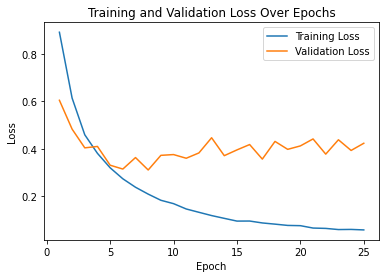

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

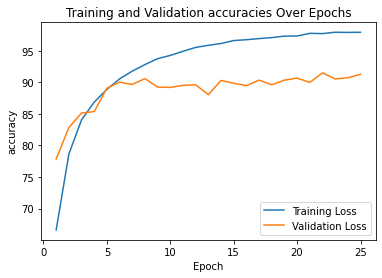

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Loss')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracies Over Epochs')
plt.legend()
plt.show()

# Model Analysis

In [21]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             240
         MaxPool2d-2           [-1, 24, 56, 56]               0
            Conv2d-3           [-1, 24, 28, 28]             216
       BatchNorm2d-4           [-1, 24, 28, 28]              48
            Conv2d-5           [-1, 58, 28, 28]           1,392
       BatchNorm2d-6           [-1, 58, 28, 28]             116
              ReLU-7           [-1, 58, 28, 28]               0
            Conv2d-8           [-1, 58, 56, 56]           1,392
       BatchNorm2d-9           [-1, 58, 56, 56]             116
             ReLU-10           [-1, 58, 56, 56]               0
           Conv2d-11           [-1, 58, 28, 28]             522
      BatchNorm2d-12           [-1, 58, 28, 28]             116
           Conv2d-13           [-1, 58, 28, 28]           3,364
      BatchNorm2d-14           [-1, 58,

In [22]:
import re
from ptflops import get_model_complexity_info
from pthflops import count_ops

macs, params = get_model_complexity_info(model, (1, 224,224), as_strings=True,print_per_layer_stat=False, verbose=False)
# # Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

Computational complexity: 145.14 MMac
Computational complexity: 290.28 MFlops
Number of parameters: 1.26 M  


# Testing 

In [23]:
# choosing the best model from validation loss.

best_epoch=np.argmin(val_losses)
print('best_epoch:',best_epoch)

best_epoch: 7


In [24]:
ckpt = torch.load(directory+'/mymodel_'+str(best_epoch)+'.pth')
model.load_state_dict(ckpt)
model.eval()


ShuffleNet2(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): Sequential(
    (0): ShuffleBlock(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(58, 58, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=58, bias=False)
        (4): 

In [25]:
from tqdm import tqdm

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(test_dataloader))

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f'testing')

y_true_val = []
y_pred_val = []


model.eval()
for batch_idx, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)
    #images=images/255
    optimizer.zero_grad()

    outputs = model(images)

    y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
    y_true_val.extend(labels.detach().tolist())



    # Update progress bar description with current loss



total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
total = len(y_true_val)
test_accuracy = total_correct * 100 / total

print("-------------------------------------------------")
print("TEST Accuracy (%): ", test_accuracy, "==", total_correct, "/", total)
print("-------------------------------------------------")


10831


testing: 100%|██████████| 10831/10831 [05:21<00:00, 33.66it/s]

-------------------------------------------------
TEST Accuracy (%):  90.1417228326101 == 78106 / 86648
-------------------------------------------------


In [ ]:
test_accuracy_dic={"best epoch":[best_epoch],
          "test_accuracy":[test_accuracy]}

df = pd.DataFrame.from_dict(test_accuracy_dic) 
path=directory+'/test_accuracy.csv'
df.to_csv (path, index = False, header=True)

# Demo on Test data

In [ ]:
import matplotlib.pyplot as plt

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

int_to_class = {0:"NORMAL" , 1:"DRUSEN", 2:"DME" ,3:"CNV"}  
# Function to show images
def show_images(images, labels,predictions):
    plt.figure(figsize=(30, 30))
    for i in range(len(images)):
        plt.subplot(len(images),1 , i + 1)
        plt.title(f"GT: {int_to_class[labels[i].item()]} \n prediction: {int_to_class[predictions[i]]}")
        plt.imshow(images[i][0], cmap="gray")
        plt.axis('off')
    plt.show()

# Display a batch of images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    outputs_cpu=outputs.detach().argmax(dim=-1).tolist()
    print(outputs_cpu)
    print(labels)
    
    break  # Show only the first batch
    
    
images=images.to('cpu')
    
show_images(images,labels,outputs_cpu)